In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, make_scorer

# Carregando os dados

In [107]:
df = pd.read_csv("data/desafio_indicium_imdb.csv", index_col=0)

# Informações Iniciais

In [108]:
df

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Breakfast at Tiffany's,1961,A,115 min,"Comedy, Drama, Romance",7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,Audrey Hepburn,George Peppard,Patricia Neal,Buddy Ebsen,166544,NaN
996,Giant,1956,G,201 min,"Drama, Western",7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,34075,NaN
997,From Here to Eternity,1953,Passed,118 min,"Drama, Romance, War",7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,"30,500,000"
998,Lifeboat,1944,NaN,97 min,"Drama, War",7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,26471,NaN


Pode-se visualizar que o dataset é ordenado com base em IMDB_rating, de forma descendente.

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 124.9+ KB


É preciso tratar algumas colunas:
- Released_Year: a coluna deveria ser ```int```.
- Runtime: a coluna de duração do filme está em formato ```object``` porque tem o texto ```' mins'``` junto aos minutos.
- Gross: a coluna de renda bruta está em formato ```object``` porque os números possuem vírgulas separando milhões e milhares.

In [110]:
nrows_df = df.shape[0]
nrows_df_na = df[df.isna().any(axis=1)].shape[0]

perc_na = 100 * (nrows_df_na)/nrows_df
print(f"{perc_na:.2f}% das linhas têm algum valor faltante em df")

28.63% das linhas têm algum valor faltante em df


In [111]:
df.isnull().sum()

Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

As colunas ```Certificate```, ```Meta_score``` e ```Gross``` têm entre 10 a 15% de valores faltantes, o que é uma quantidade considerável. Como visto acima, utilizar o ```dropna()``` removeria quase 30% da base de dados. Vamos avaliar outras alternativas.

In [112]:
print(f"{df.duplicated().sum()} linhas duplicadas em df")

0 linhas duplicadas em df


# Tratamento de Dados

## Released_Year

In [113]:
# df['Released_Year'].astype(int, errors='raise')

O código anterior retorna um erro que 'PG' não pode virar integer.

In [114]:
# Checando os valores que a coluna possui
df['Released_Year'].unique()

array(['1972', '2008', '1974', '1957', '2003', '1994', '1993', '2010',
       '1999', '2001', '1966', '2002', '1990', '1980', '1975', '2020',
       '2019', '2014', '1998', '1997', '1995', '1991', '1977', '1962',
       '1954', '1946', '2011', '2006', '2000', '1988', '1985', '1968',
       '1960', '1942', '1936', '1931', '2018', '2017', '2016', '2012',
       '2009', '2007', '1984', '1981', '1979', '1971', '1963', '1964',
       '1950', '1940', '2013', '2005', '2004', '1992', '1987', '1986',
       '1983', '1976', '1973', '1965', '1959', '1958', '1952', '1948',
       '1944', '1941', '1927', '1921', '2015', '1996', '1989', '1978',
       '1961', '1955', '1953', '1925', '1924', '1982', '1967', '1951',
       '1949', '1939', '1937', '1934', '1928', '1926', '1920', '1970',
       '1969', '1956', '1947', '1945', '1930', '1938', '1935', '1933',
       '1932', '1922', '1943', 'PG'], dtype=object)

In [115]:
# Será que houve um erro de leitura? 'PG' é um valor válido para Certificate
df[df['Released_Year']=='PG']

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
966,Apollo 13,PG,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"


Não foi um erro de leitura, as outras colunas estão corretas. Segundo o IMDB, Apollo 13 foi um filme de 1995.

In [116]:
# Editar o valor de Released_Year de 'Apollo 13'
df.loc[df["Series_Title"] == "Apollo 13", "Released_Year"] = 1995
df[df['Series_Title']=='Apollo 13']

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
966,Apollo 13,1995,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"


In [117]:
df['Released_Year'] = df['Released_Year'].astype(int)

## Runtime e Gross

In [118]:
# Transformando a coluna 'Runtime' em numérica, removendo o texto ' min'
df['Runtime'] = df['Runtime'].str.replace(" min", "").astype(int)

df['Gross'] = df['Gross'].str.replace(",", "").astype(float) # float pra aceitar os NaN, usar int dá erro

In [119]:
# checando os Dtypes resultantes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    int64  
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    int64  
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    float64
dtypes: float64(3), int64(3), object(9)
memory usage: 124.9+ KB


## Certificate (Classificação Etária)

A coluna certificate pode ser alterada para a idade mínima permitida para facilitar a leitura.

In [120]:
df['Certificate'].value_counts()

Certificate
U           234
A           196
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
Unrated       1
TV-MA         1
16            1
U/A           1
Name: count, dtype: int64

In [121]:
certificate_map = {
    "G": "0",
    "U": "0",
    "Passed": "0",
    "Approved": "0",
    "PG": "12",
    "GP": "12",
    "UA": "12",
    "U/A": "12",
    "TV-PG": "12",
    "PG-13": "13",
    "TV-14": "14",
    "16": "16",
    "R": "18",
    "A": "18",
    "TV-MA": "18",
    "NC-17": "18",
    "Unrated": "NR",
    "NR": "NR"
}

# aplicando ao dataframe
df["Certificate"] = df["Certificate"].map(certificate_map)
df = df.rename(columns={"Certificate": "Age_Rating"})

In [122]:
print(f"{100*df["Age_Rating"].isna().sum()/df.shape[0]:.2f}% das linhas da coluna 'Age_Rating' são nulas.")

10.11% das linhas da coluna 'Age_Rating' são nulas.


## Drop NA

In [123]:
df.dropna(inplace=True)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 713 entries, 1 to 997
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   713 non-null    object 
 1   Released_Year  713 non-null    int64  
 2   Age_Rating     713 non-null    object 
 3   Runtime        713 non-null    int64  
 4   Genre          713 non-null    object 
 5   IMDB_Rating    713 non-null    float64
 6   Overview       713 non-null    object 
 7   Meta_score     713 non-null    float64
 8   Director       713 non-null    object 
 9   Star1          713 non-null    object 
 10  Star2          713 non-null    object 
 11  Star3          713 non-null    object 
 12  Star4          713 non-null    object 
 13  No_of_Votes    713 non-null    int64  
 14  Gross          713 non-null    float64
dtypes: float64(3), int64(3), object(9)
memory usage: 89.1+ KB


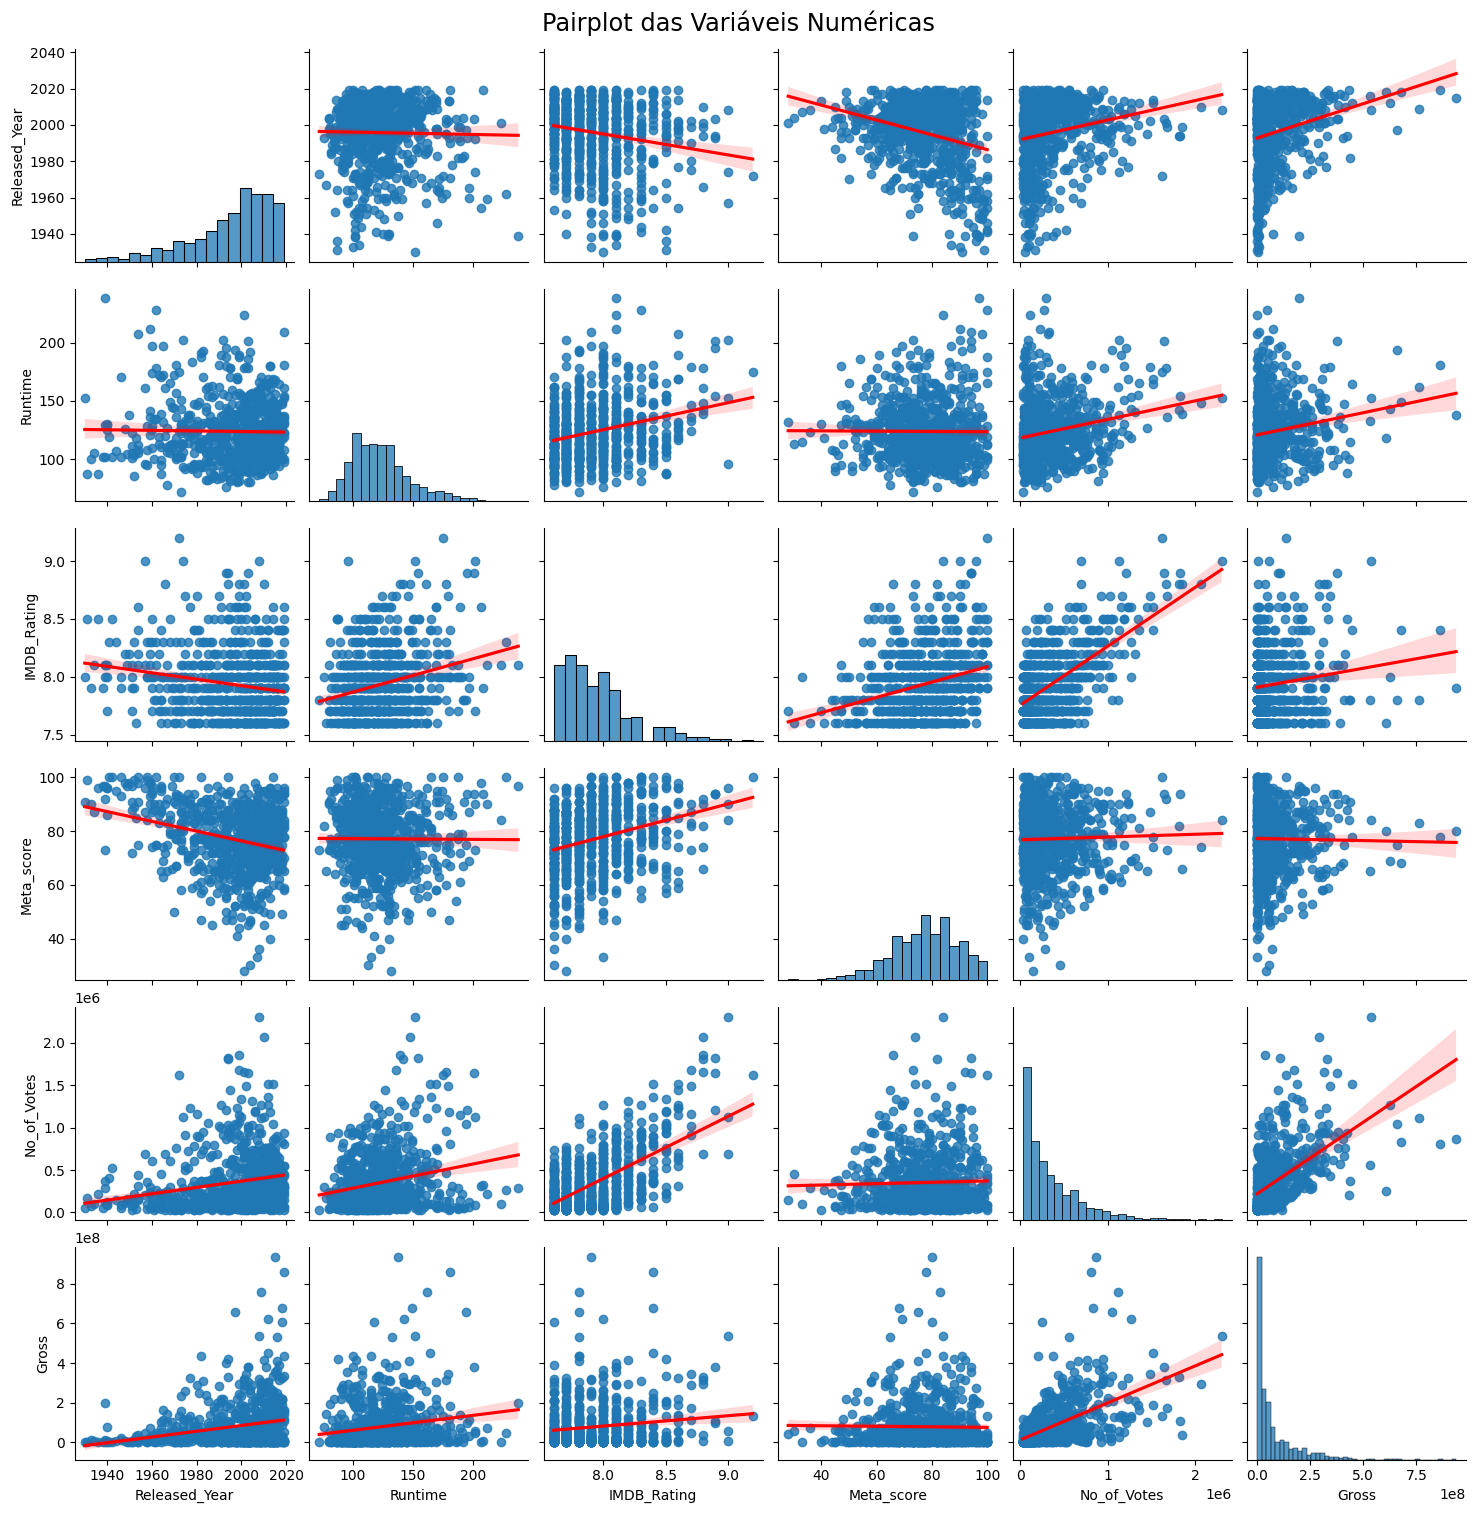

In [125]:
pairplot = sns.pairplot(data=df, kind='reg', plot_kws={"line_kws": {"color": "red"}})

pairplot.figure.suptitle("Pairplot das Variáveis Numéricas", y=1.01, fontsize='xx-large')

plt.show()

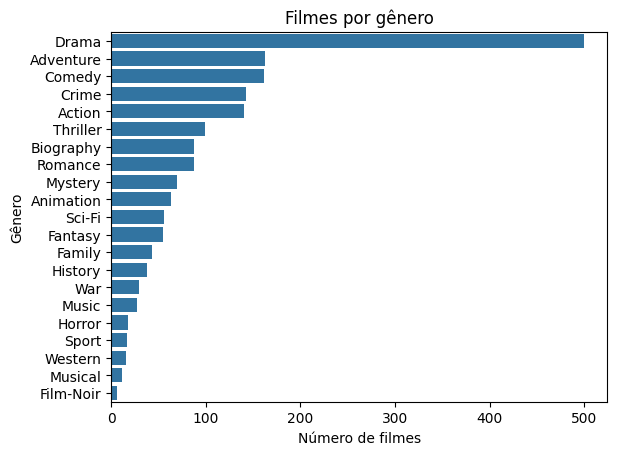

In [126]:
df_exploded = df["Genre"].str.split(",").explode().str.strip()

genre_counts = df_exploded.value_counts().reset_index()

sns.barplot(genre_counts, y=genre_counts['Genre'], x=genre_counts['count'])
plt.ylabel("Gênero")
plt.xlabel("Número de filmes")
plt.title("Filmes por gênero")
plt.show()

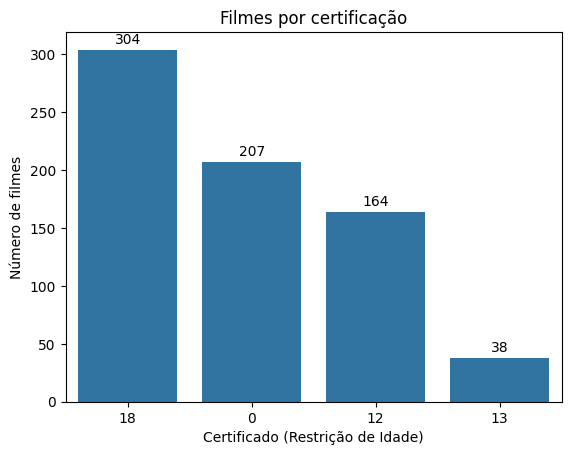

In [127]:
age_rating_counts = df['Age_Rating'].value_counts().reset_index()
age_rating_counts.columns = ["Age_Rating", "count"]

# cria o gráfico
ax = sns.barplot(data=age_rating_counts, x="Age_Rating", y="count")

# adiciona os valores nas barras
for container in ax.containers:
    ax.bar_label(container, label_type="edge", padding=2)

# personalização
plt.ylabel("Número de filmes")
plt.xlabel("Certificado (Restrição de Idade)")
plt.title("Filmes por certificação")
plt.show()

In [128]:
actors = df.melt(
    id_vars=["Series_Title"], 
    value_vars=["Star1", "Star2", "Star3", "Star4"],
    value_name="Actor"
)["Actor"]

actor_counts = actors.value_counts().reset_index().head(15)

actor_counts

,Actor,count
0,Robert De Niro,16
1,Tom Hanks,14
2,Al Pacino,13
3,Brad Pitt,12
4,Leonardo DiCaprio,11
5,Clint Eastwood,11
6,Matt Damon,11
7,Christian Bale,11
8,Denzel Washington,9
9,Scarlett Johansson,9


In [129]:
df

,Series_Title,Released_Year,Age_Rating,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,18,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,The Dark Knight,2008,12,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,The Godfather: Part II,1974,18,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,12 Angry Men,1957,0,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0
5,The Lord of the Rings: The Return of the King,2003,0,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,Giù la testa,1971,12,157,"Drama, War, Western",7.6,A low-life bandit and an I.R.A. explosives exp...,77.0,Sergio Leone,Rod Steiger,James Coburn,Romolo Valli,Maria Monti,30144,696690.0
991,Kelly's Heroes,1970,12,144,"Adventure, Comedy, War",7.6,A group of U.S. soldiers sneaks across enemy l...,50.0,Brian G. Hutton,Clint Eastwood,Telly Savalas,Don Rickles,Carroll O'Connor,45338,1378435.0
992,The Jungle Book,1967,0,78,"Animation, Adventure, Family",7.6,Bagheera the Panther and Baloo the Bear have a...,65.0,Wolfgang Reitherman,Phil Harris,Sebastian Cabot,Louis Prima,Bruce Reitherman,166409,141843612.0
994,A Hard Day's Night,1964,0,87,"Comedy, Music, Musical",7.6,"Over two ""typical"" days in the life of The Bea...",96.0,Richard Lester,John Lennon,Paul McCartney,George Harrison,Ringo Starr,40351,13780024.0


In [130]:
df.columns

Index(['Series_Title', 'Released_Year', 'Age_Rating', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 713 entries, 1 to 997
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   713 non-null    object 
 1   Released_Year  713 non-null    int64  
 2   Age_Rating     713 non-null    object 
 3   Runtime        713 non-null    int64  
 4   Genre          713 non-null    object 
 5   IMDB_Rating    713 non-null    float64
 6   Overview       713 non-null    object 
 7   Meta_score     713 non-null    float64
 8   Director       713 non-null    object 
 9   Star1          713 non-null    object 
 10  Star2          713 non-null    object 
 11  Star3          713 non-null    object 
 12  Star4          713 non-null    object 
 13  No_of_Votes    713 non-null    int64  
 14  Gross          713 non-null    float64
dtypes: float64(3), int64(3), object(9)
memory usage: 89.1+ KB


In [132]:
# Transformar gênero em lista
df['Genre_list'] = df['Genre'].apply(lambda x: [g.strip() for g in x.split(',')])

# Combinar todos os atores em uma lista
df['Actors_list'] = df[['Star1', 'Star2', 'Star3', 'Star4']].values.tolist()


In [133]:
mlb_genre = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb_genre.fit_transform(df['Genre_list']),
                             columns=mlb_genre.classes_,
                             index=df.index)

mlb_actors = MultiLabelBinarizer()
actors_encoded = pd.DataFrame(mlb_actors.fit_transform(df['Actors_list']),
                              columns=mlb_actors.classes_,
                              index=df.index)


In [134]:
# Exemplo: prever IMDB_Rating
y = df['Gross']

# Selecionar variáveis numéricas que não sejam o alvo
X_numeric = df[['Runtime', 'Meta_score', 'No_of_Votes', 'IMDB_Rating']]

# Concatenar tudo
X = pd.concat([X_numeric, genre_encoded, actors_encoded], axis=1)


In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [141]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6]
}

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2'
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='R2',
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [None, 2, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,"{'MAE': 'neg_mean_absolute_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,n_jobs,-1
,refit,'R2'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,300


In [142]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Melhores parâmetros:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
MAE: 46158719.28
RMSE: 96911263.66
R²: 0.45


In [143]:
# Importâncias
importances = best_rf.feature_importances_

# Colunas correspondentes
columns = X.columns

# Criar DataFrame para visualização
feature_importance_df = pd.DataFrame({
    'Feature': columns,
    'Importance': importances
})

# Ordenar do mais importante para o menos importante
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df.head(20)  # mostra as top 20


,Feature,Importance
2,No_of_Votes,0.389370
5,Adventure,0.143010
1542,Robert Downey Jr.,0.044708
3,IMDB_Rating,0.040964
0,Runtime,0.036668
1,Meta_score,0.027146
890,Joe Russo,0.022409
1203,Mark Ruffalo,0.015895
11,Family,0.015134
1300,Michelle Rodriguez,0.012944


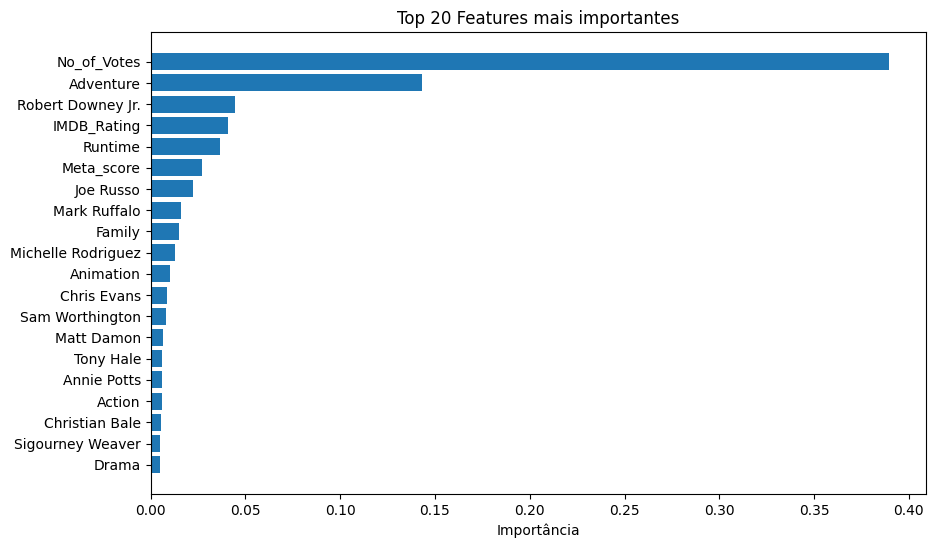

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'][:20][::-1], feature_importance_df['Importance'][:20][::-1])
plt.xlabel("Importância")
plt.title("Top 20 Features mais importantes")
plt.show()
